### Import Dependencies

In [48]:
from pathlib import Path
from pynwb import NWBHDF5IO
import numpy as np
import matplotlib.pyplot as plt
from dandi import dandiapi, download
import os
import pandas as pd
from scipy.signal import medfilt
from scipy.interpolate import interp1d

%matplotlib inline

In [2]:
output_dir = "./plots"
output_dir = Path(output_dir)
output_dir.mkdir(exist_ok=True)

### Download and Open NWB file
The NWB files can be found in Dandiset 001424 on DANDI. The NWB can be downloaded with the DANDI client and then opened with pynwb

In [3]:
dandiset_id = "001424"
# dandi_filepath = "sub-794237/sub-794237_ses-20250403T103830_image+ophys.nwb"
# dandi_filepath = "sub-794237/sub-794237_ses-20250424T142019_image+ophys.nwb"
dandi_filepath = "sub-794237/sub-794237_ses-20250508T145040_image+ophys.nwb"
download_loc = "."

In [4]:
client = dandiapi.DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id)
file = dandiset.get_asset_by_path(dandi_filepath)
file_url = file.download_url
filename = dandi_filepath.split("/")[-1]
filepath = f"{download_loc}/{filename}"
if os.path.exists(filepath):
    print("File already exists")
else:
    # This can sometimes take a while depending on the size of the file
    download.download(file_url, output_dir=download_loc)
    print(f"Downloaded file to {filepath}")

PATH                                           SIZE   DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-794237_ses-20250508T145040_image+ophys.nwb 2.8 GB 2.8 GB           100%    ok    done                   
Summary:                                       2.8 GB 2.8 GB                         1 done                 
                                                      100.00%                                               
Downloaded file to ./sub-794237_ses-20250508T145040_image+ophys.nwb


In [5]:
io = NWBHDF5IO(filepath, mode="r", load_namespaces=True)
nwb = io.read()

c:\Users\carter.peene\AppData\Local\Programs\Python\Python313\Lib\site-packages\pynwb\file.py:158: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['date_of_birth'] = _add_missing_timezone(date_of_birth)


The NWB and its sections are rendered in the notebook here for easy exploration. The most important sections are `intervals` which contains the stimulus information, and `processing` which contains the processed ophys recording.

In [6]:
nwb

Data type,float64
Shape,"(1, 323, 832)"
Array size,2.05 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(1,)"
Array size,8.00 bytes
Chunk shape,None


### Viewing the Traces

In [ ]:
dmd = 1 # or 2
f0 = nwb.processing['ophys'][f'DMD{dmd}_f0']
df = nwb.processing['ophys']['df'].roi_response_series[f'DMD{dmd}_df']
dff = nwb.processing['ophys']['dff'].roi_response_series[f'DMD{dmd}_dff']

In [ ]:
table = nwb.processing['ophys']['ImageSegmentation'].plane_segmentations[f'DMD{dmd}_plane_segmentation']

120

Text(0.5, 80.7222222222222, 'Time (s)')

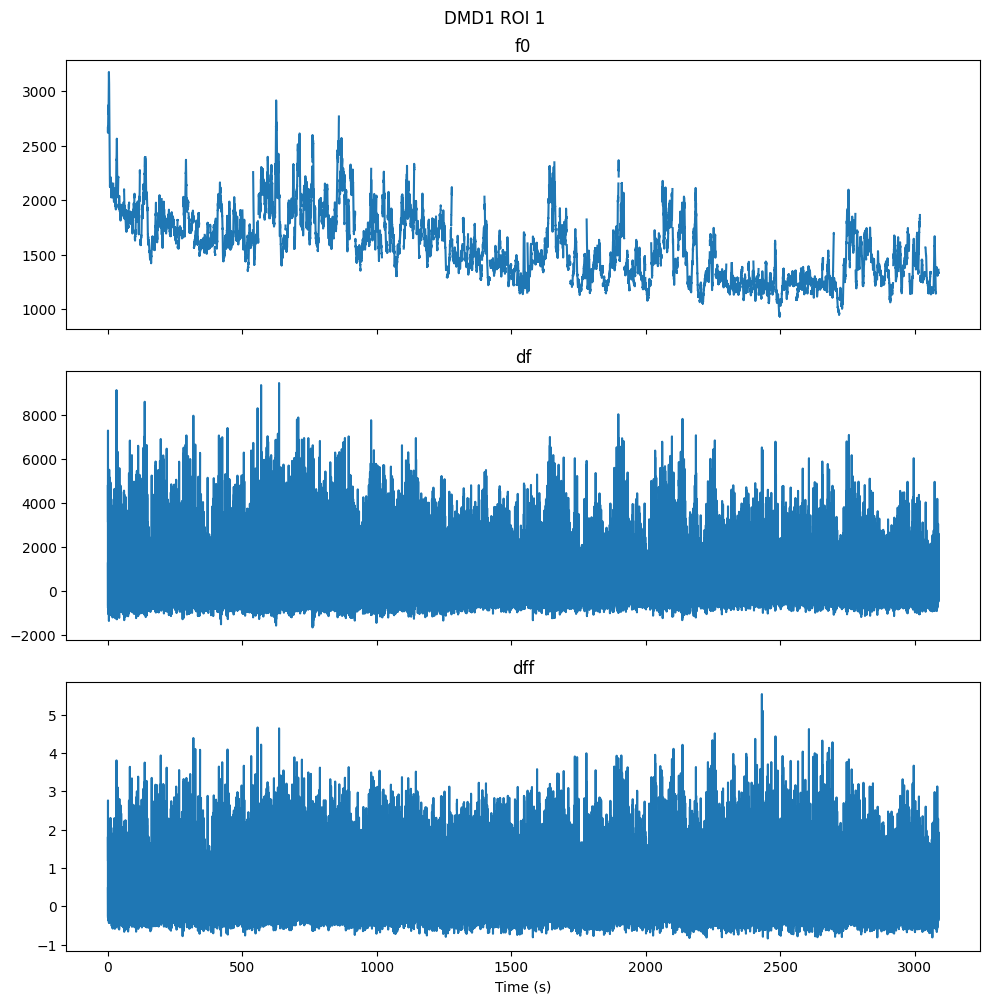

In [43]:
roi = 1
f0_trace = np.array(f0.data[:, roi])
f0_timestamps = np.array(f0.timestamps)

df_trace = np.array(df.data[:, roi])
df_timestamps = np.array(df.timestamps)

dff_trace = np.array(dff.data[:, roi])
dff_timestamps = np.array(dff.timestamps)

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(f0_timestamps, f0_trace, label='f0')
axs[0].set_title('f0')
axs[1].plot(df_timestamps, df_trace, label='df')
axs[1].set_title('df')
axs[2].plot(dff_timestamps, dff_trace, label='dff')
axs[2].set_title('dff')
plt.suptitle(f'DMD{dmd} ROI {roi}')
plt.tight_layout()
plt.xlabel('Time (s)')

### Reproducing F0 and DFF

### Information in exptSummary.E{}
The ophys module contains traces for the following fields:

* dF ('delta F') : Baseline-subtracted fluorescence
* F0: An estimate of the fluorescence baseline
* dFF ('delta F over F') : Baseline-subtracted fluorescence divided by baseline, i.e. fractional change in fluorescence.

```
Tip:  
dF vs dFF
When performing analyses of glutamate imaging, the more useful variable is dF, which has units proportional to photons. 

For example, a good estimate of the total measured glutamate input to the cell is the sum of dF across synapses. It is inappropriate to sum dFF in the same way, because very dim synapses can have large dFF values and background fluorescence (e.g. from the dendritic shaft) strongly affects fractional changes at some synapses compared to others. This is different than population Calcium imaging, which tends to work with dF/F. 

In glutamate imaging, dFF is most useful for compensating for bleaching over time for a single synapse, for example to see if its activity increases vs decreases over the course of an experiment. However even for this some confounds remain due to brightness-dependent bias in F0 estimation. 
```
For SLAP2, there are two simultaneously-imaged fields of view, and the traces in the two trials should have the same or very similar numbers of timepoints. For analysis, the two FOVs can be merged- the data are interpolated onto the same timebase.


In [ ]:
def algo1(Fin, denoise_window, hull_window):
    if denoise_window % 2 == 0:
        denoise_window += 1

    # Ensure input is a numpy array
    Fin = np.asarray(Fin)
    T = Fin.shape[0]
    hull_window = min(hull_window, T // 4)
    delta_des = max(4, denoise_window // 6)

    sample_times = np.round(np.linspace(0, T - 1, int(np.ceil(T / delta_des)) + 1)).astype(int)
    n_samps_in_hull = int(np.ceil(hull_window / delta_des))

    # Apply median filter
    F0 = pd.DataFrame(Fin).apply(lambda col: medfilt(col, kernel_size=denoise_window), axis=0).values

    F0 = F0.reshape(T, -1)
    for cix in range(F0.shape[1]):
        col = F0[:, cix]
        if np.all(np.isnan(col)):
            continue

        F00 = np.empty((len(sample_times), n_samps_in_hull))
        F00[:] = np.nan

        for dix in reversed(range(n_samps_in_hull)):
            xi = sample_times[dix::n_samps_in_hull]
            valid = ~np.isnan(col[xi])
            if np.sum(valid) < 2:
                continue
            interp_func = interp1d(xi[valid], col[xi][valid], kind='linear', bounds_error=False, fill_value='extrapolate')
            F00[:, dix] = interp_func(sample_times)

        # Minimum across interpolations
        FF = np.nanmin(F00, axis=1)

        # Discard uncertain estimates
        doubt = np.sum(~np.isnan(F00), axis=1) < np.ceil(n_samps_in_hull / 2)
        F2 = FF.copy()
        F2[doubt] = np.nan

        # Smooth missing data using moving average
        series = pd.Series(F2)
        fill = series.rolling(window=2 * int(np.ceil(n_samps_in_hull / 2)) + 1, min_periods=1, center=True).mean()
        F2[np.isnan(F2)] = fill[np.isnan(F2)]
        # Final smoothing
        series = pd.Series(F2)
        F2 = series.rolling(window=2 * int(np.ceil(n_samps_in_hull / 2)) + 1, min_periods=1, center=True).mean().values

        interp_final = interp1d(sample_times, F2, kind='cubic', bounds_error=False, fill_value='extrapolate')
        F0[:, cix] = interp_final(np.arange(T))

    return F0


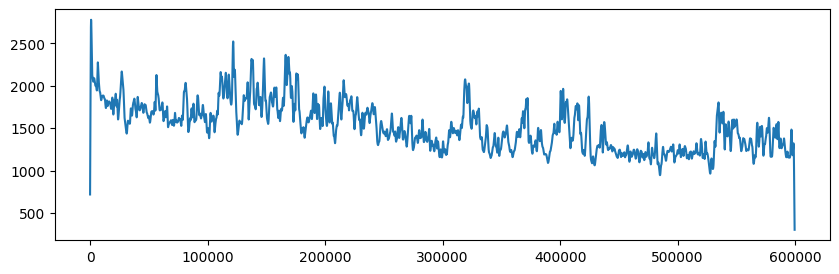

In [62]:
mdiff = np.mean(np.diff(df_timestamps))
new_f0 = algo1(f0_trace, denoise_window=int(0.25 / mdiff), hull_window=int(3 / mdiff))
fig, axs = plt.subplots(1, 1, figsize=(10, 3), sharex=True)
plt.plot(new_f0)

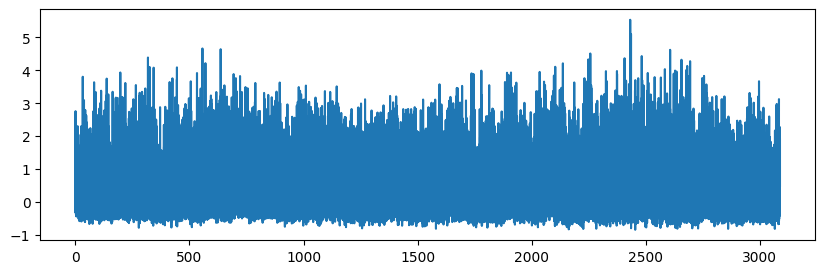

In [47]:
new_dff_trace = df_trace / f0_trace
fig, axs = plt.subplots(1, 1, figsize=(10, 3), sharex=True)
plt.plot(df_timestamps, new_dff_trace, label='new dff')